In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.60107  # in  --> Confirmed with template explanation
text_height = 9.0

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})


def errorfill(ax, x, y, yerr, color=None, alpha_fill=0.3, alpha_line=1, lw=1, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label=None):
    ax.fill_between(x, y - yerr, y + yerr, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=alpha_line, label=label, marker=marker, markersize=markersize)

def remove_xticks(ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=False)
    ax.set_xticklabels([])
        
def remove_yticks(ax):
    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    ax.yaxis.set_tick_params(which='minor', left=False)
    ax.set_yticklabels([])


In [3]:
from scalable_gps.wandb_utils import load_runs_from_regex
import numpy as np
import os

def get_splits(dataset, model):
    # if dataset == '3droad':
    #     return [0, 1, 2, 4, 5, 6, 7, 8, 9]
    # elif (dataset == 'song' or dataset =='houseelectric') and 'cg' in model:
    #     return [0, 1, 2, 3, 4]
    # elif dataset == 'buzz' and model == 'precondcg':
    #     return [0, 1, 2, 3, 4]
    if dataset in ['song', 'buzz', 'houseelectric']:
        return [0, 1, 2, 3, 4]
    elif dataset == '3droad':
        return [0, 1, 2, 4]
    else:
        return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_n_steps(dataset, model):
    if dataset in ['kin40k', 'song', 'buzz', 'houseelectric'] and model == 'sgd':
        return 100
    elif dataset in ['song', 'buzz', 'houseelectric'] and 'cg' in model:
        return 100
    else:
        return 1000

datasets = ['pol',
            # 'elevators',
            # 'bike',
            # 'kin40k',
            # 'protein',
            'keggdirected',
            '3droad',
            # 'song',
            # 'buzz',
            'houseelectric']
models = ['sgd', 'cg', 'precondcg']

config_keys = ['dataset_config.split', 'model_name', 'compute_exact_soln']
metric_keys = ['wall_clock_time', 'train/normalised_test_rmse', 'train/test_rmse']

rmse_trace_path = "./rmse_trace.npy"

if os.path.isfile(rmse_trace_path):
    rmse_trace = np.load(rmse_trace_path, allow_pickle=True).item()
else:
    rmse_trace = dict()

for dataset in datasets:
    if dataset not in rmse_trace.keys():
        rmse_trace[dataset] = dict()

    for model in models:
        if model in rmse_trace[dataset].keys():
            print(f"rmse trace for {dataset}, {model} already exists")
            continue
        splits = get_splits(dataset, model)
        n_steps = get_n_steps(dataset, model)
        seed_regex = f"({splits})".replace(", ", "|")
        n_splits = len(splits)
        rmse_trace[dataset][model] = dict()

        for metric in metric_keys:
            rmse_trace[dataset][model][metric] = np.zeros((n_splits, n_steps))
    
        regex = f"^final_{dataset}_{model}_{seed_regex}$"
        
        print(f"Downloading results for {dataset}, {model}")
        configs_and_metrics = load_runs_from_regex(regex, config_keys=config_keys, metric_keys=metric_keys)

        for (configs, metrics) in configs_and_metrics:
            if configs['compute_exact_soln']:
                continue
            split = splits.index(configs['dataset_config.split'])
            assert model == configs['model_name']

            for metric in metric_keys:
                rmse_trace[dataset][model][metric][split] = metrics[metric]
        np.save(rmse_trace_path, rmse_trace)

rmse trace for pol, sgd already exists
rmse trace for pol, cg already exists
rmse trace for pol, precondcg already exists
rmse trace for keggdirected, sgd already exists
rmse trace for keggdirected, cg already exists
rmse trace for keggdirected, precondcg already exists
rmse trace for 3droad, sgd already exists
rmse trace for 3droad, cg already exists
rmse trace for 3droad, precondcg already exists
rmse trace for houseelectric, sgd already exists
rmse trace for houseelectric, cg already exists
rmse trace for houseelectric, precondcg already exists


In [4]:
from scalable_gps.wandb_utils import load_runs_from_regex
import numpy as np
import os

def get_splits(dataset):
    if dataset == '3droad':
        return [0, 1, 2, 4]
    else:
        return [0, 1, 2, 3, 4]

def get_n_steps(dataset, model):
    if model == 'sgd':
        if dataset in ['houseelectric']:
            return 10
        elif dataset in ['3droad']:
            return 1000
        else:
            return 100
    elif 'cg' in model:
        if dataset in ['song', 'buzz', 'houseelectric']:
            return 100
        else:
            return 1000

datasets = ['pol',
            # 'elevators',
            # 'bike',
            # 'kin40k',
            # 'protein',
            'keggdirected',
            '3droad',
            # 'song',
            # 'buzz',
            'houseelectric']
models = ['sgd', 'cg']

config_keys = ['dataset_config.split', 'model_name', 'compute_exact_soln', 'sampling_config.eval_every']
metric_keys = ['normalised_test_llh', 'test_llh']

llh_trace_path = "./llh_trace.npy"

if os.path.isfile(llh_trace_path):
    llh_trace = np.load(llh_trace_path, allow_pickle=True).item()
else:
    llh_trace = dict()

for dataset in datasets:
    if dataset not in llh_trace.keys():
        llh_trace[dataset] = dict()
    
    splits = get_splits(dataset)

    for model in models:
        if model in llh_trace[dataset].keys():
            print(f"llh trace for {dataset}, {model} already exists")
            continue

        n_steps = get_n_steps(dataset, model)
        seed_regex = f"({splits})".replace(", ", "|")
        n_splits = len(splits)
        llh_trace[dataset][model] = dict()

        for metric in metric_keys:
            llh_trace[dataset][model][metric] = np.zeros((n_splits, n_steps))
    
        regex = f"samples_final_{dataset}_{model}_{seed_regex}$"
        
        print(f"Downloading results for {dataset}, {model}")
        configs_and_metrics = load_runs_from_regex(regex, config_keys=config_keys, metric_keys=metric_keys)

        for (configs, metrics) in configs_and_metrics:
            if configs['compute_exact_soln']:
                continue
            if dataset == '3droad' and model =='sgd' and configs['sampling_config.eval_every'] != 100:
                continue
            split = splits.index(configs['dataset_config.split'])
            assert model == configs['model_name']
            print(dataset, model, split)

            for metric in metric_keys:
                llh_trace[dataset][model][metric][split] = metrics[metric][:n_steps]
        np.save(llh_trace_path, llh_trace)

llh trace for pol, sgd already exists
llh trace for pol, cg already exists
llh trace for keggdirected, sgd already exists
llh trace for keggdirected, cg already exists
llh trace for 3droad, sgd already exists
llh trace for 3droad, cg already exists
llh trace for houseelectric, sgd already exists
llh trace for houseelectric, cg already exists


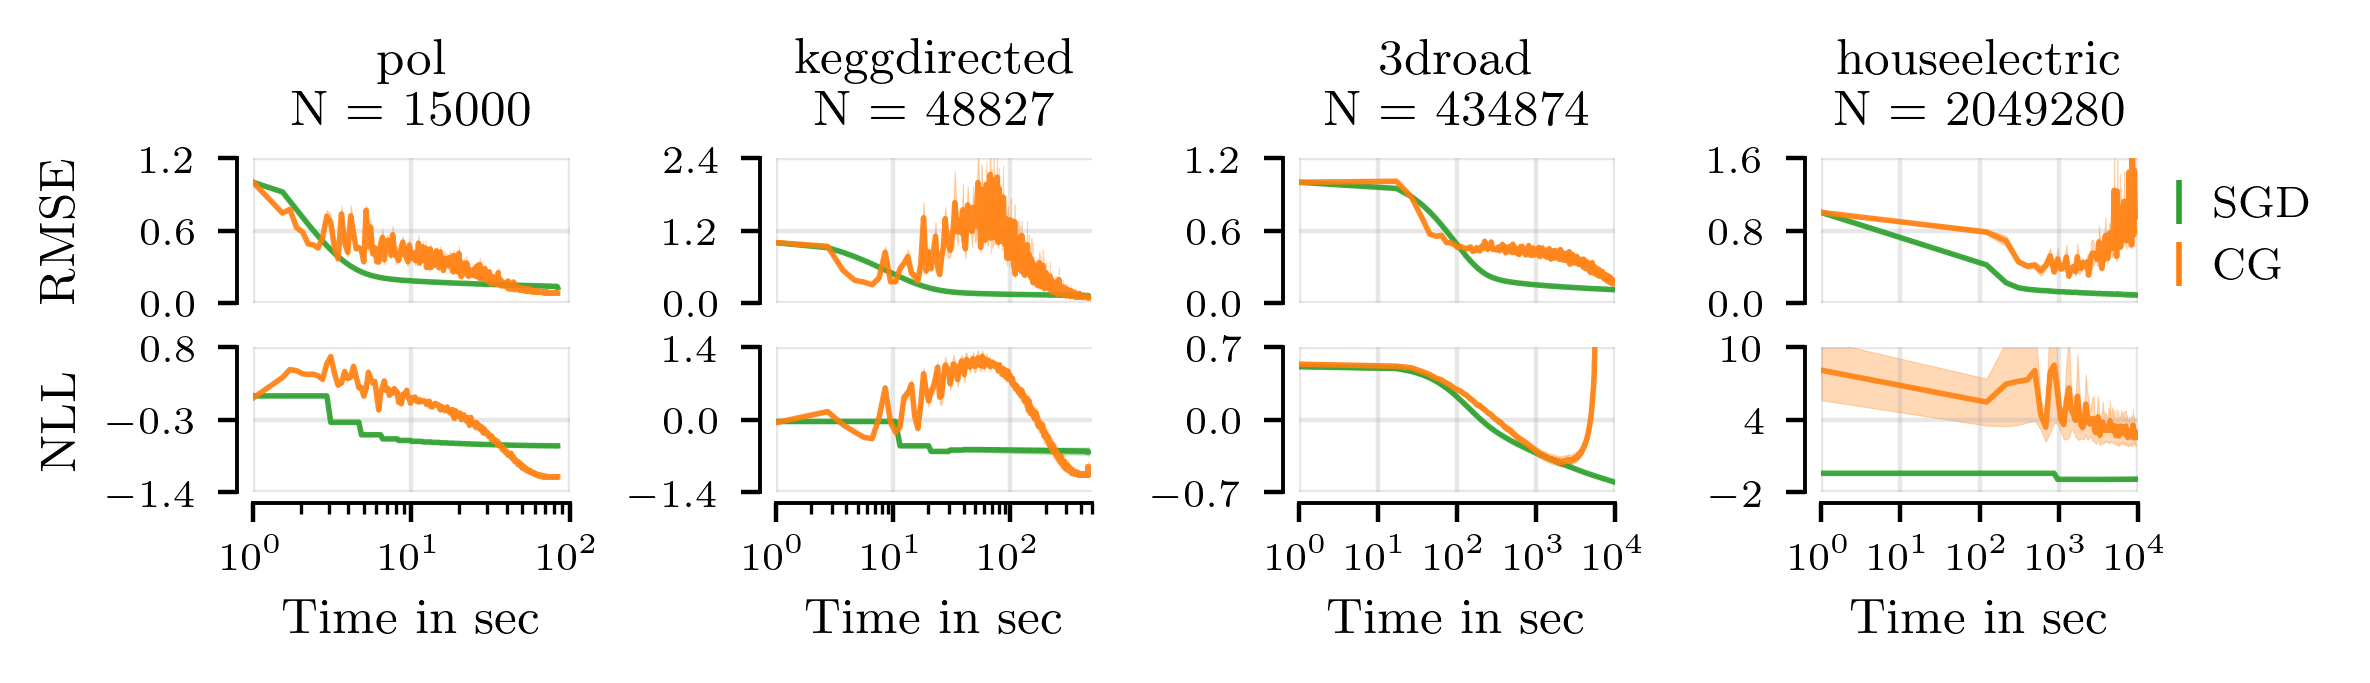

In [5]:
def get_color(model):
    if 'cg' in model:
        return 'tab:orange'
    elif 'sgd' in model:
        return 'tab:green'
    else:
        return 'magenta'

def get_label(model):
    if 'cg' in model:
        return "CG"
    elif 'sgd' in model:
        return "SGD"
    else:
        return 'null'
    
def get_yticks(dataset):
    if dataset == 'pol':
        return [(0.0, 0.6, 1.2),
                (-1.4, -0.3, 0.8)]
    elif dataset == 'keggdirected':
        return [(0, 1.2, 2.4),
                (-1.4, 0.,  1.4)]
    elif dataset == '3droad':
        return [(0, 0.6, 1.2),
                (-.7, 0.0, 0.7)]
    elif dataset == 'houseelectric':
        return [(0, 0.8, 1.6),
                (-2, 4, 10)]
    else:
        return [(0, 1), (0, 1)]

alpha_line = 0.9

titles = ["test rmse", "y pred rmse", "alpha rmse in eucl", None, "alpha rmse in rkhs", None]
metrics = ['train/normalised_test_rmse', 'normalised_test_llh']
models = ['sgd', 'cg']

S = 'pol'
M = 'keggdirected'
L = '3droad'
XL = 'houseelectric'

fig = plt.figure(dpi=400, figsize=[text_width, 0.2 * text_height])
gs = GridSpec(2, 4, figure=fig)
yticks = get_yticks(dataset)

S_rmse = fig.add_subplot(gs[0, 0])
S_llh = fig.add_subplot(gs[1, 0])
M_rmse = fig.add_subplot(gs[0, 1])
M_llh = fig.add_subplot(gs[1, 1])
L_rmse = fig.add_subplot(gs[0, 2])
L_llh = fig.add_subplot(gs[1, 2])
XL_rmse = fig.add_subplot(gs[0, 3])
XL_llh = fig.add_subplot(gs[1, 3])

# add pol, N = 100 ...
S_rmse.set_title("pol\nN = 15000")#, D = 26")
M_rmse.set_title("keggdirected\nN = 48827")#, D = 20")
L_rmse.set_title("3droad\nN = 434874")#, D = 3")
XL_rmse.set_title("houseelectric\nN = 2049280")#, D = 11")

axes_rmse = [S_rmse, M_rmse, L_rmse, XL_rmse]
axes_llh = [S_llh, M_llh, L_llh, XL_llh]
axes = axes_rmse + axes_llh

S_rmse.set_ylabel("RMSE")
S_llh.set_ylabel("NLL")

for i, ax in enumerate(axes):
    ax.grid(alpha=0.3)
    ax.semilogx()
    ax.set_xlabel("Time in sec")

    ax.spines[['top', 'right']].set_visible(False)
    ax.spines['bottom'].set_position(('axes', -0.075))
    ax.spines['left'].set_position(('axes', -0.05))

for i, (dataset, max_time) in enumerate(zip([S, M, L, XL], [100, 500, 10000, 10000])):
    xlim = (1, max_time)
    yticks_rmse, yticks_llh = get_yticks(dataset)
    time = rmse_trace[dataset][model]['wall_clock_time'][0]
    time = time - time[0] + xlim[0]
    for metric, ax, trace, yticks, sgn in zip(metrics, [axes_rmse, axes_llh], [rmse_trace, llh_trace], [yticks_rmse, yticks_llh], [1, -1]):
        for model in models:
            c = get_color(model)
            
            ax[i].set_xlim(xlim)
            if max_time == 10000:
                ax[i].set_xticks([1, 10, 100, 1000, 10000])
            ax[i].set_yticks(yticks)
            ax[i].set_ylim(np.min(yticks), np.max(yticks))

            mean = sgn * np.mean(trace[dataset][model][metric], axis=0)
            err = np.std(trace[dataset][model][metric], axis=0) / np.sqrt(trace[dataset][model][metric].shape[0])
            stretch_factor = int(len(time) / len(mean))
            mean = np.repeat(mean, stretch_factor)
            err = np.repeat(err, stretch_factor)
            # print(dataset, model, stretch_factor)
            errorfill(ax[i], time, mean, err, color=c, alpha_line=alpha_line)

for ax in axes_rmse:
    ax.spines['bottom'].set_visible(False)
    remove_xticks(ax)
    ax.set_xlabel(None)

legend_handles = []
for model in models:
    c = get_color(model)
    label = get_label(model)
    legend_handles.append(Line2D([], [], marker='|', linestyle='None', markersize=8, markeredgewidth=1, color=c, label=label))
fig.legend(handles=legend_handles, ncols=1, loc='center', bbox_to_anchor=(1.01, 0.65), fontsize=8, frameon=False, handlelength=0)

fig.align_labels()
fig.tight_layout(w_pad=0.5, h_pad=0.2)
fig.savefig(f"../../figures/rmse_llh_trace.pdf", bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../../figures/rmse_llh_trace.png", bbox_inches='tight', pad_inches=0.01)